In [1]:
using Plots
pyplot(fmt=:png);

In [2]:
using DiffEQ
using Param

In [3]:
@with_kw type HPParam
    a1::Float64
    a2::Float64
    b1::Float64
    b2::Float64
    d1::Float64
    d2::Float64
end

The default parameters set with $b_1 = 3.0$

In [4]:
param = HPParam(
    a1 = 5.0, 
    a2 = 0.1, 
    b1 = 3.0, 
    b2 = 2.0, 
    d1 = 0.4, 
    d2 = 0.01
);

In [16]:
@withparam HPParam par function model(t, y, par::HPParam)
    yprime = zeros(3)
    yprime[1] = y[1]*(1 - y[1]) - a1*y[1]*y[2]/(1 + b1*y[1])
    yprime[2] = a1*y[1]*y[2]/(1 + b1*y[1]) - a2*y[2]*y[3]/(1 + b2*y[2]) - d1*y[2]
    yprime[3] = a2*y[2]*y[3]/(1 + b2*y[2]) - d2*y[3]
    return yprime
end

model (generic function with 1 method)

In [6]:
sol = aode(Dopri54((t, x) -> model(t, x, param), [0.8, 0.2, 10.0]), 0.0:10000);
# small perturburbation to initial conditions
sol_div = aode(Dopri54((t, x) -> model(t, x, param), [0.81, 0.21, 10.1]), 0.0:10000);


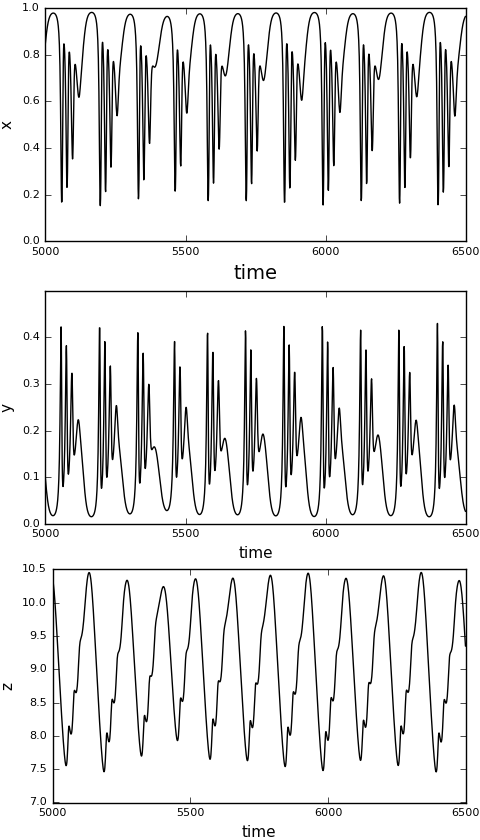

In [56]:
default(legend=false, grid=false) #TODO: this is global shold likely be with using statement as a result
t1 = 5000
t2 = 6500
lfont = font()
xticks = [5000, 5500, 6000, 6500] # Plots.jl check that is is an AbstractVector so tuples do not work, see if this is intended
p1 = plot(sol.x[t1:t2], sol.y[t1:t2, 1], lc=:black, xguidefont=lfont, xlim=(t1, t2), xticks=xticks, ylim=(0, 1), yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], xlabel="time", ylabel="x")
p2 = plot(sol.x[t1:t2], sol.y[t1:t2, 2], lc=:black, xlim=(t1, t2), xticks=xticks, ylim=(0, 0.5), yticks=[0, 0.1, 0.2, 0.3, 0.4], xlabel="time", ylabel="y")
p3 = plot(sol.x[t1:t2], sol.y[t1:t2, 3], lc=:black, xlim=(t1, t2), xticks=xticks, ylim=(7, 10.5), yticks=[7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5], xlabel="time", ylabel="z")
plot(p1, p2, p3, layout=GridLayout(3, 1), size=[0.8*600, 3*0.8*350])

In [51]:
?font

search: font lfont FileMonitor unsafe_pointer_to_objref FixedPointNumbers



Create a Font from a list of unordered features


Now the attractor in 3D. Behold the teacup!


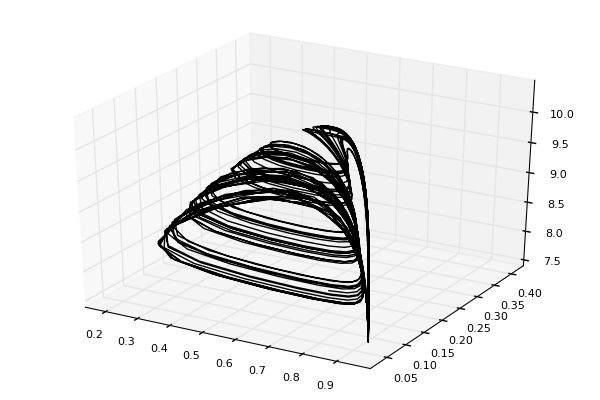

In [8]:
t1 = 8000
t2 = 10000
plot3d(sol.y[t1:t2, 1], sol.y[t1:t2, 2], sol.y[t1:t2, 3], c=:black, orientation=(30, 80))

Now we look at how small perturbations to the initial conditions lead to significant changes in the schape of the solution.


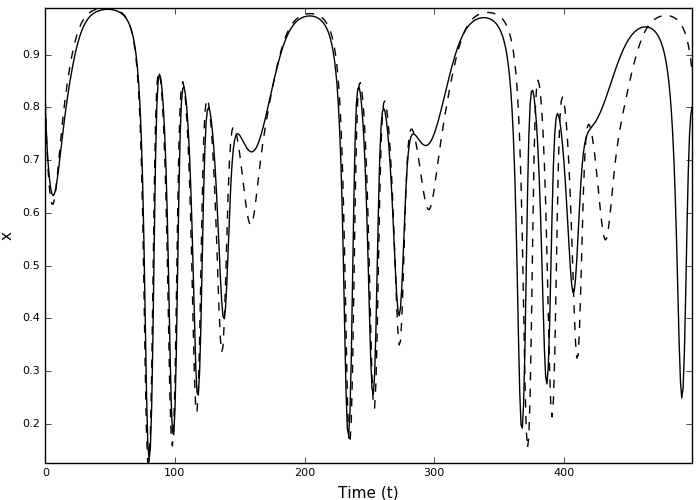

In [9]:
p = plot(sol.x[1:500], sol.y[1:500, 1], c=:black, size=(700, 500))
plot!(p, sol_div.x[1:500], sol_div.y[1:500, 1], c=:black, s=:dash)
xlabel!(p, "Time (t)")
ylabel!(p, "x")

## Bifurcation Analysis

Following the authors we will look at the local maxes for the last 5000 points (5000:10000) for changes in $b_1$ between 2.0 and 3.2 in steps of 0.01

In [10]:
function local_max(ts::AbstractVector{Float64})
    lmaxs = Float64[]
    for i in 2:(length(ts) - 3)
        if ts[i - 1] < ts[i] && ts[i] > ts[i + 1]
            push!(lmaxs, ts[i])
        end
    end
    return lmaxs
end

local_max (generic function with 1 method)

In [11]:
##TODO: if I explictly use the "ExplicitRungeKutta" method in Mathematica this code is around 64sec/24sec = 2.6 times faster
## make this a benchmark problem. Now if I use the ParallelTable for solving the ODE I can get it so that Mathematica
## is 24/22 = 1.09 times faster. Still this is crushing ... and require that I use a C compiler for the localMax function.
function bif_analysis(b1vals)
    bparam = HPParam(5.0, 0.1, 3.0, 2.0, 0.4, 0.01)
    system = Dopri54((t, y) -> model(t, y, bparam), [0.8, 0.2, 10.0])
    # the number of local maxes varies so we need a ragged array
    bpoints = []
    for b1 in b1vals
        # since mutable types are passed by reference this just works :)
        bparam.b1 = b1
        bsol = aode(system, 0.0:10000)
        for m in local_max(bsol.y[5000:10000, 3])
            push!(bpoints, [b1, m])
        end
    end
    return bpoints
end

bif_analysis (generic function with 1 method)

In [12]:
@time bpoints = bif_analysis(2.2:0.001:3.2);

 17.350826 seconds (320.22 M allocations: 16.247 GB, 13.12% gc time)


In [13]:
bpoints = hcat(bpoints...)';


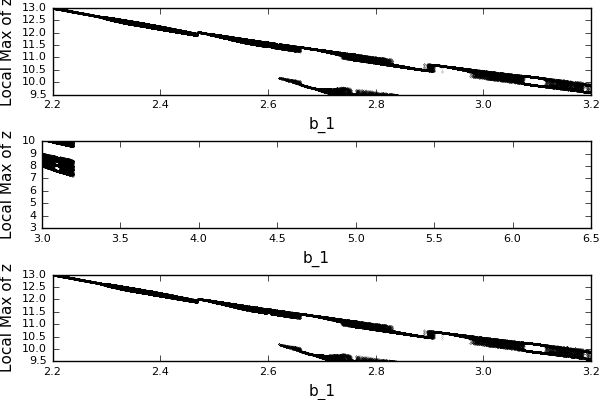

In [14]:
p1 = scatter(bpoints[:, 1], bpoints[:, 2], ylim=(9.5, 13.0), xlabel="b_1", ylabel="Local Max of z", markersize = 0.1)
p2 = scatter(bpoints[:, 1], bpoints[:, 2], ylim=(3.0, 10.0), xlim=(3, 6.5), xlabel="b_1", ylabel="Local Max of z", markersize = 0.1)
p3 = scatter(bpoints[:, 1], bpoints[:, 2], ylim=(9.5, 13.0), xlabel="b_1", ylabel="Local Max of z", markersize = 0.1)
plot(p1, p2, p3, layout=@layout([a; b; c]))

In [ ]:
p = scatter(bpoints[1:50000, 1], bpoints[1:50000, 2], ylim=(10.5, 13), markersize=0.08)
xlabel!(p, "b_1")
ylabel!(p, "Local Max of z")